Imports

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Finding the Areas of Interest with a quantile over all 110 hurricanes.

In [2]:
def tp_quantile(directory):

    tp_values = []
    files = [f for f in os.listdir(directory) if f.endswith('.grib')]
    
    for name in files:

        filepath = os.path.join(directory, name)
        
        rainfall = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}}).to_dataframe()
        vals = rainfall.tp

        tp_values.append(vals)

    return tp_values

In [3]:
%%capture

tp_arrays = tp_quantile("..\data_grib")

In [4]:
tp_values = pd.concat([arr for arr in tp_arrays])

In [5]:
tp_95_quantile = tp_values.quantile(0.95)

In [6]:
tp_95_quantile

np.float32(0.0013141632)

The 95% tp quantile is 0.0013141632

In [7]:
def ws10_quantile(directory):

    ws10_values = []
    files = [f for f in os.listdir(directory) if f.endswith('.grib')]
    
    for name in files:

        filepath = os.path.join(directory, name)
        
        speeds = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}}).to_dataframe()
        u_speed = speeds.u10
        v_speed = speeds.v10
        ws10 = np.sqrt(u_speed**2 + v_speed**2)

        ws10_values.append(ws10)

    return ws10_values

In [8]:
%%capture

ws10_arrays = ws10_quantile("../data_grib")

In [9]:
ws10_values = pd.concat([arr for arr in ws10_arrays])

In [10]:
ws10_95_quantile = ws10_values.quantile(0.95)

In [11]:
ws10_95_quantile

np.float64(11.48831558227539)

The ws10 95% quantile is 11.48831558227539

EDA for Hurricane Abby

In [12]:
speeds = xr.open_dataset("../data_grib/ABBY_1968_07.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}})
rainfall = xr.open_dataset("../data_grib/ABBY_1968_07.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}})
extra = xr.open_dataset("../data_grib/ABBY_1968_07.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [134, 34]}})

Ignoring index file '../data_grib/ABBY_1968_07.grib.5b7b6.idx' incompatible with GRIB file
Ignoring index file '../data_grib/ABBY_1968_07.grib.5b7b6.idx' incompatible with GRIB file
Ignoring index file '../data_grib/ABBY_1968_07.grib.5b7b6.idx' incompatible with GRIB file


In [13]:
speeds = speeds.to_dataframe()
rainfall = rainfall.to_dataframe()
extra = extra.to_dataframe()

In [14]:
u_speed = speeds.u10
v_speed = speeds.v10
ws10 = np.sqrt(u_speed**2 + v_speed**2)

speeds["ws10"] = ws10

In [15]:
mask_ws10 = speeds['ws10'] > ws10_95_quantile
mask_tp = rainfall['tp'] > tp_95_quantile

In [16]:
#Finding the coordinates that experience weather above the thresholds at some point

temp = mask_ws10.groupby(["latitude", "longitude"]).sum()
mask_ws10_average = temp > 0

temp = mask_tp.groupby(["latitude", "longitude"]).sum()
mask_tp_average = temp > 0

In [17]:
#Averaging wind speed and tp over time

ws10_average = speeds["ws10"].groupby(["latitude", "longitude"]).mean()
tp_average = rainfall["tp"].groupby(["latitude", "longitude"]).mean()

In [18]:
combined_mask = mask_ws10_average & mask_tp_average

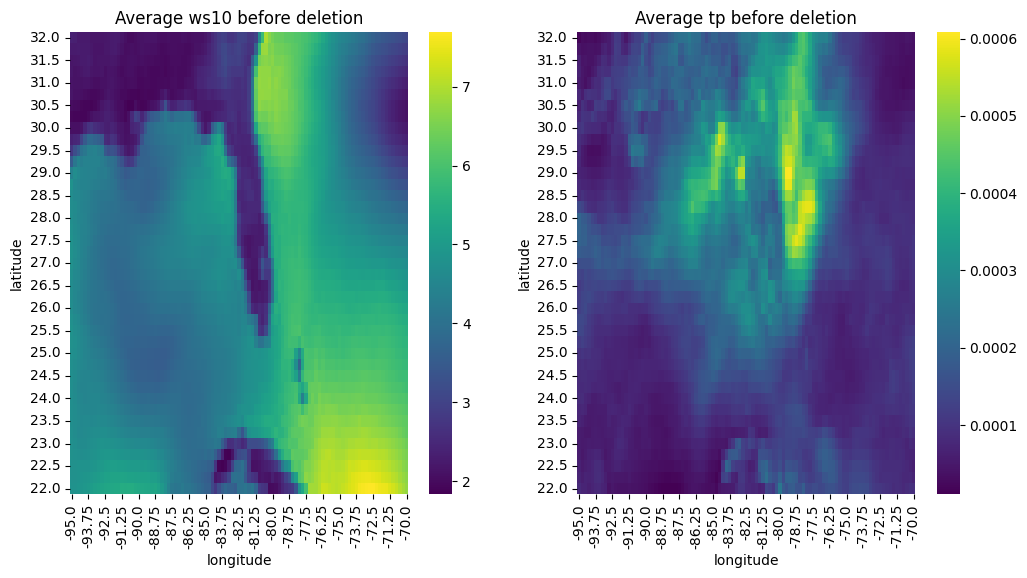

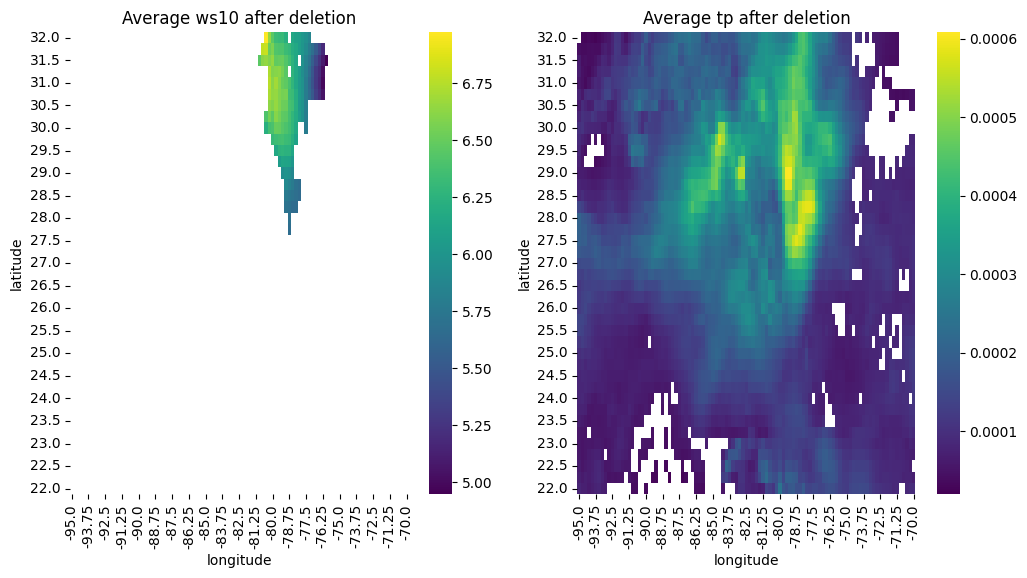

In [19]:
# Plot data before deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(ws10_average.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average ws10 before deletion')

plt.subplot(122)
sns.heatmap(tp_average.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average tp before deletion')
plt.show()

# Apply the mask and remove data from locations below thresholds
ws10_filtered = ws10_average.where(mask_ws10_average)
tp_filtered = tp_average.where(mask_tp_average)

# Plot data after deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(ws10_filtered.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average ws10 after deletion')

plt.subplot(122)
sns.heatmap(tp_filtered.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average tp after deletion')
plt.show()

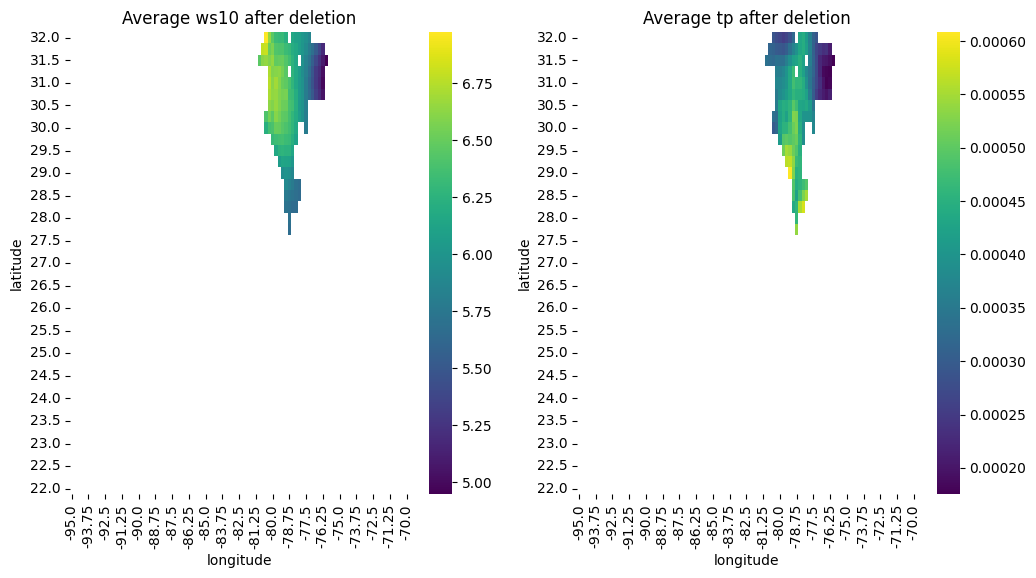

In [20]:
# Apply the mask and remove data from locations below thresholds
ws10_filtered_combined = ws10_average.where(combined_mask)
tp_filtered_combined = tp_average.where(combined_mask)

# Plot data after deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(ws10_filtered_combined.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average ws10 after deletion')

plt.subplot(122)
sns.heatmap(tp_filtered_combined.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average tp after deletion')
plt.show()

In [21]:
sp_average = extra["sp"].groupby(["latitude", "longitude"]).mean()
sst_average = extra["sst"].groupby(["latitude", "longitude"]).mean()

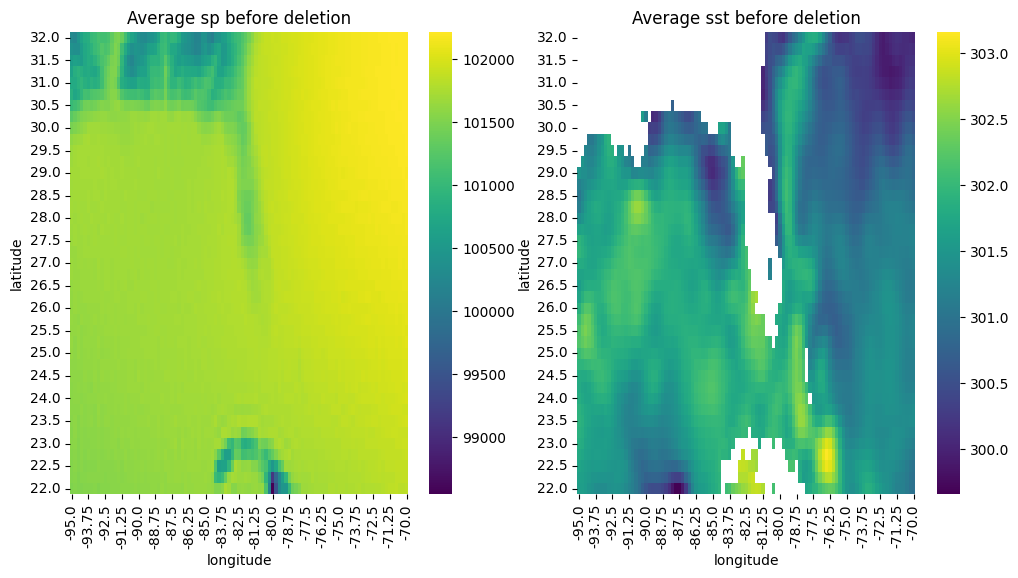

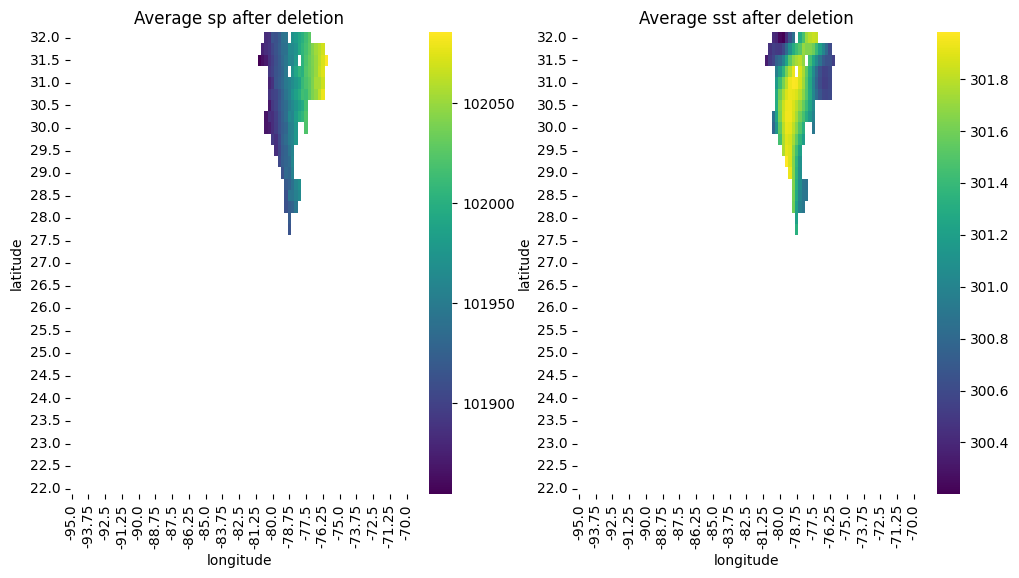

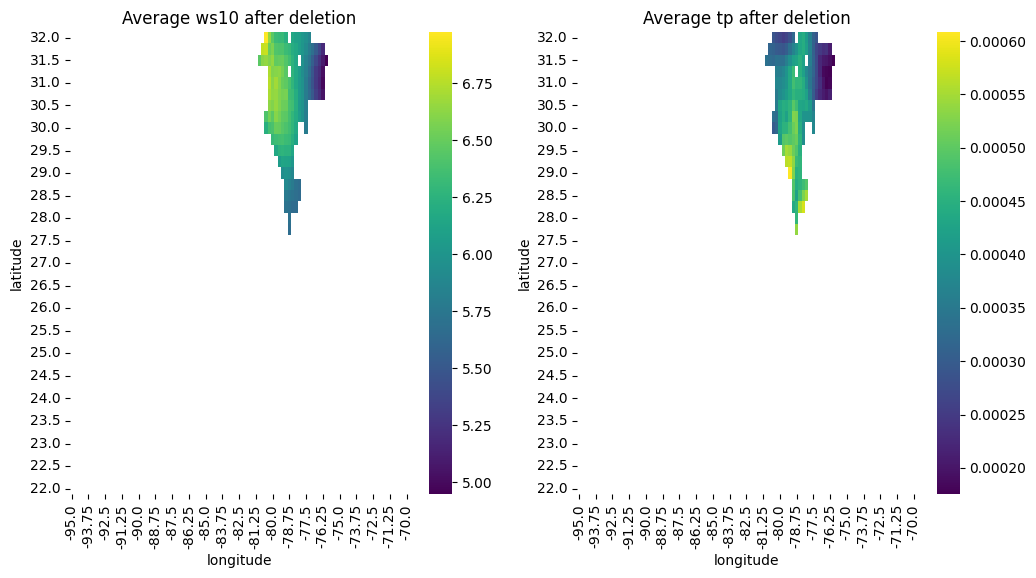

In [22]:
# Plot data before deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(sp_average.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average sp before deletion')

plt.subplot(122)
sns.heatmap(sst_average.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average sst before deletion')
plt.show()

# Apply the mask and remove data from locations below thresholds
sp_filtered = sp_average.where(combined_mask)
sst_filtered = sst_average.where(combined_mask)

# Plot data after deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(sp_filtered.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average sp after deletion')

plt.subplot(122)
sns.heatmap(sst_filtered.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average sst after deletion')
plt.show()

# Plot data after deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(ws10_filtered_combined.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average ws10 after deletion')

plt.subplot(122)
sns.heatmap(tp_filtered_combined.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average tp after deletion')
plt.show()

Hurricane Abby was Cat 1. Lets analyse a more serious hurricane such as Michael in 2018 which was Cat 5.

EDA for Hurricane Michael.

In [23]:
speeds = xr.open_dataset("../data_grib/MICHAEL_2018_10.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}})
rainfall = xr.open_dataset("../data_grib/MICHAEL_2018_10.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}})
extra = xr.open_dataset("../data_grib/MICHAEL_2018_10.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [134, 34]}})

Ignoring index file '../data_grib/MICHAEL_2018_10.grib.5b7b6.idx' incompatible with GRIB file
Ignoring index file '../data_grib/MICHAEL_2018_10.grib.5b7b6.idx' incompatible with GRIB file
Ignoring index file '../data_grib/MICHAEL_2018_10.grib.5b7b6.idx' incompatible with GRIB file


In [24]:
speeds = speeds.to_dataframe()
rainfall = rainfall.to_dataframe()
extra = extra.to_dataframe()

In [25]:
u_speed = speeds.u10
v_speed = speeds.v10
ws10 = np.sqrt(u_speed**2 + v_speed**2)

speeds["ws10"] = ws10

In [26]:
mask_ws10 = speeds['ws10'] > ws10_95_quantile
mask_tp = rainfall['tp'] > tp_95_quantile

In [27]:
#Finding the coordinates that experience weather above the thresholds at some point

temp = mask_ws10.groupby(["latitude", "longitude"]).sum()
mask_ws10_average = temp > 0

temp = mask_tp.groupby(["latitude", "longitude"]).sum()
mask_tp_average = temp > 0

In [28]:
#Averaging wind speed and tp over time

ws10_average = speeds["ws10"].groupby(["latitude", "longitude"]).mean()
tp_average = rainfall["tp"].groupby(["latitude", "longitude"]).mean()

In [29]:
combined_mask = mask_ws10_average & mask_tp_average

In [30]:
sp_average = extra["sp"].groupby(["latitude", "longitude"]).mean()
sst_average = extra["sst"].groupby(["latitude", "longitude"]).mean()

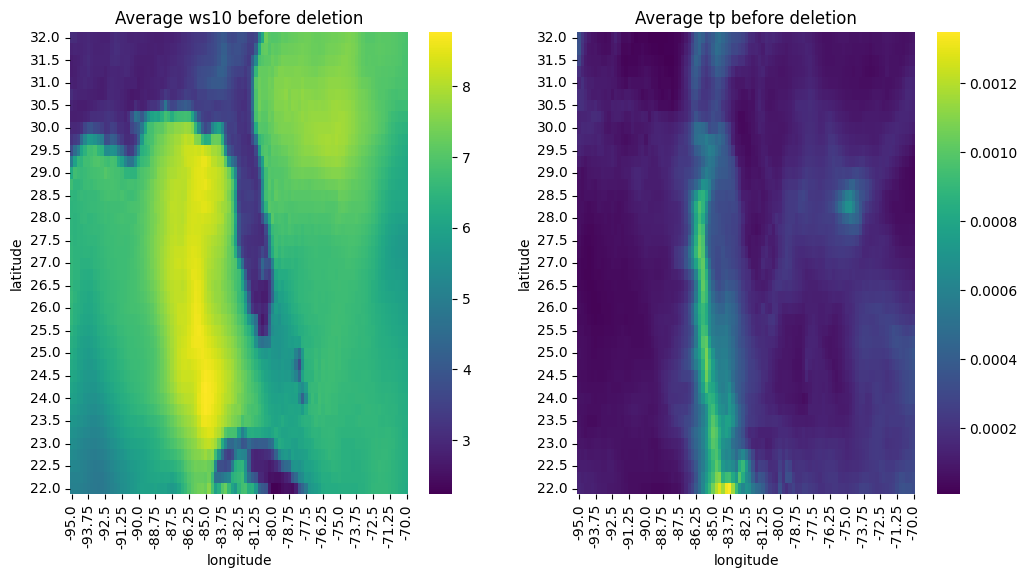

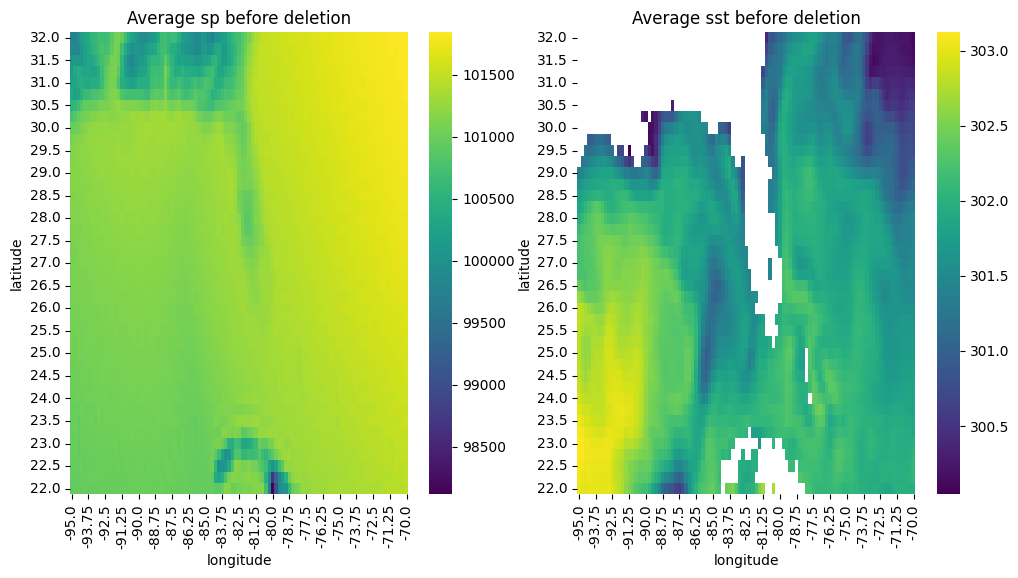

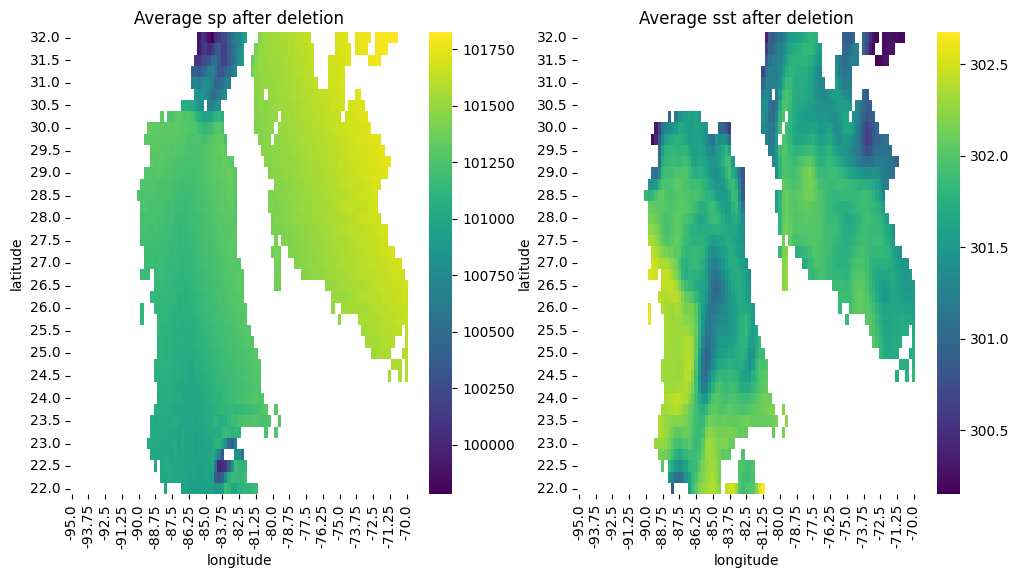

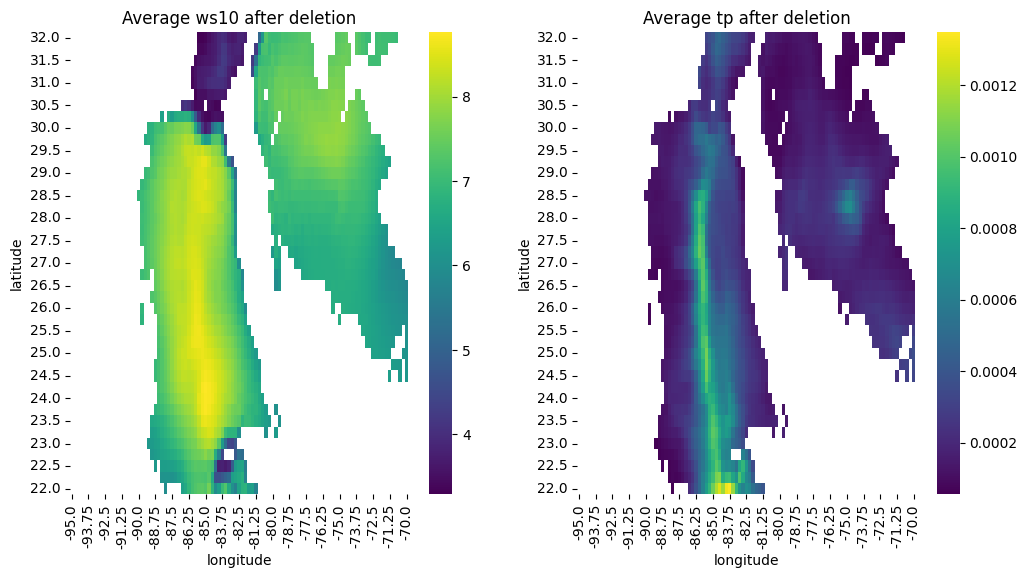

In [31]:
# Plot data before deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(ws10_average.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average ws10 before deletion')

plt.subplot(122)
sns.heatmap(tp_average.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average tp before deletion')
plt.show()

# Plot data before deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(sp_average.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average sp before deletion')

plt.subplot(122)
sns.heatmap(sst_average.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average sst before deletion')
plt.show()

# Apply the mask and remove data from locations below thresholds
ws10_filtered_combined = ws10_average.where(combined_mask)
tp_filtered_combined = tp_average.where(combined_mask)
sp_filtered = sp_average.where(combined_mask)
sst_filtered = sst_average.where(combined_mask)

# Plot data after deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(sp_filtered.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average sp after deletion')

plt.subplot(122)
sns.heatmap(sst_filtered.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average sst after deletion')
plt.show()

# Plot data after deletion
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(ws10_filtered_combined.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average ws10 after deletion')

plt.subplot(122)
sns.heatmap(tp_filtered_combined.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average tp after deletion')
plt.show()

Much more area experiences an extreme weather event.

What quantile to use?

In [68]:
def retained_data(speed_data, rainfall_data, ws10_threshold, tp_threshold):

    speed_data = speed_data.to_dataframe()
    rainfall_data = rainfall_data.to_dataframe()

    u_speed = speed_data.u10
    v_speed = speed_data.v10
    ws10 = np.sqrt(u_speed**2 + v_speed**2)

    speed_data["ws10"] = ws10

    mask_ws10 = speed_data['ws10'] > ws10_threshold
    mask_tp = rainfall_data['tp'] > tp_threshold

    temp = mask_ws10.groupby(["latitude", "longitude"]).sum()
    mask_ws10_average = temp > 0

    temp = mask_tp.groupby(["latitude", "longitude"]).sum()
    mask_tp_average = temp > 0

    combined_mask = mask_ws10_average & mask_tp_average

    return combined_mask.sum() / len(combined_mask)

In [69]:
retained_data(speeds, rainfall, ws10_threshold, tp_threshold)

np.float64(0.6157932866457377)

In [79]:
%%capture

retained_values = []
files = [f for f in os.listdir("../data_grib") if f.endswith('.grib')]

ws10_threshold = ws10_values.quantile(0.95)
tp_threshold = tp_values.quantile(0.95)
    
for name in files:

    filepath = os.path.join("../data_grib", name)
        
    rainfall = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}})
    speeds = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}})

    vals = retained_data(speeds, rainfall, ws10_threshold, tp_threshold)

    retained_values.append(vals)

In [80]:
retained_95 = sum(retained_values)/len(retained_values)
retained_95

np.float64(0.28919717875908707)

In [77]:
%%capture

retained_values_90 = []
files = [f for f in os.listdir("../data_grib") if f.endswith('.grib')]

ws10_threshold = ws10_values.quantile(0.90)
tp_threshold = tp_values.quantile(0.90)
    
for name in files:

    filepath = os.path.join("../data_grib", name)
        
    rainfall = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}})
    speeds = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}})

    vals = retained_data(speeds, rainfall, ws10_threshold, tp_threshold)

    retained_values_90.append(vals)

In [78]:
retained_90 = sum(retained_values_90)/len(retained_values_90)
retained_90

np.float64(0.44265336542064637)

In [83]:
%%capture

retained_values_97 = []
files = [f for f in os.listdir("../data_grib") if f.endswith('.grib')]

ws10_threshold = ws10_values.quantile(0.97)
tp_threshold = tp_values.quantile(0.97)
    
for name in files:

    filepath = os.path.join("../data_grib", name)
        
    rainfall = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}})
    speeds = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}})

    vals = retained_data(speeds, rainfall, ws10_threshold, tp_threshold)

    retained_values_97.append(vals)

In [84]:
retained_97 = sum(retained_values_97)/len(retained_values_97)
retained_97

np.float64(0.209641182789431)

In [91]:
%%capture

retained_values_92 = []
files = [f for f in os.listdir("../data_grib") if f.endswith('.grib')]

ws10_threshold = ws10_values.quantile(0.92)
tp_threshold = tp_values.quantile(0.92)
    
for name in files:

    filepath = os.path.join("../data_grib", name)
        
    rainfall = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}})
    speeds = xr.open_dataset(filepath, engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}})

    vals = retained_data(speeds, rainfall, ws10_threshold, tp_threshold)

    retained_values_92.append(vals)

In [92]:
retained_92 = sum(retained_values_92)/len(retained_values_92)
retained_92

np.float64(0.3862302125923273)

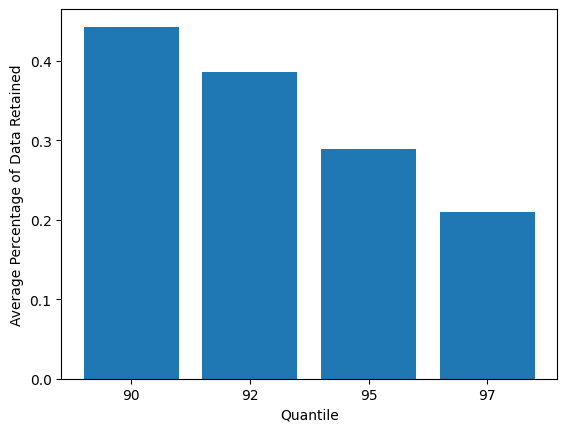

In [94]:
plt.bar(x=["90","92","95", "97"], height=[retained_90, retained_92, retained_95, retained_97])
plt.xlabel("Quantile")
plt.ylabel("Average Percentage of Data Retained");

Correlation Plots

In [32]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [49]:
test = rainfall.droplevel(level=[0,1])
vals = test.set_index([test.valid_time, test.index])
vals = vals.rename_axis(index={"valid_time":"time"})
vals

number  surface          valid_time  \
time                latitude longitude                                        
2018-10-05 19:00:00 32.0     -95.00          0      0.0 2018-10-05 19:00:00   
                             -94.75          0      0.0 2018-10-05 19:00:00   
                             -94.50          0      0.0 2018-10-05 19:00:00   
                             -94.25          0      0.0 2018-10-05 19:00:00   
                             -94.00          0      0.0 2018-10-05 19:00:00   
...                                        ...      ...                 ...   
2018-10-16 06:00:00 22.0     -71.00          0      0.0 2018-10-16 06:00:00   
                             -70.75          0      0.0 2018-10-16 06:00:00   
                             -70.50          0      0.0 2018-10-16 06:00:00   
                             -70.25          0      0.0 2018-10-16 06:00:00   
                             -70.00          0      0.0 2018-10-16 06:00:00   

                                        tp  
time                latitude longitude      
2018-10-05 19:00:00 32.0     -95.00    NaN  
                             -94.75    NaN  
                             -94.50    NaN  
                             -94.25    NaN  
                             -94.00    NaN  
...                                     ..  
2018-10-16 06:00:00 22.0     -71.00    NaN  
                             -70.75    NaN  
                             -70.50    NaN  
                             -70.25    NaN  
                             -70.00    NaN  

[1043532 rows x 4 columns]

In [36]:
speeds

number   step  surface  \
time                latitude longitude                           
2018-10-06 00:00:00 32.0     -95.00          0 0 days      0.0   
                             -94.75          0 0 days      0.0   
                             -94.50          0 0 days      0.0   
                             -94.25          0 0 days      0.0   
                             -94.00          0 0 days      0.0   
...                                        ...    ...      ...   
2018-10-15 23:00:00 22.0     -71.00          0 0 days      0.0   
                             -70.75          0 0 days      0.0   
                             -70.50          0 0 days      0.0   
                             -70.25          0 0 days      0.0   
                             -70.00          0 0 days      0.0   

                                                valid_time       u10  \
time                latitude longitude                                 
2018-10-06 00:00:00 32.0     -95.00    2018-10-06 00:00:00 -2.372269   
                             -94.75    2018-10-06 00:00:00 -1.604691   
                             -94.50    2018-10-06 00:00:00 -0.683792   
                             -94.25    2018-10-06 00:00:00 -0.112503   
                             -94.00    2018-10-06 00:00:00 -0.111526   
...                                                    ...       ...   
2018-10-15 23:00:00 22.0     -71.00    2018-10-15 23:00:00 -8.760666   
                             -70.75    2018-10-15 23:00:00 -8.827072   
                             -70.50    2018-10-15 23:00:00 -8.828049   
                             -70.25    2018-10-15 23:00:00 -8.757736   
                             -70.00    2018-10-15 23:00:00 -8.624924   

                                             v10      ws10  
time                latitude longitude                      
2018-10-06 00:00:00 32.0     -95.00     2.393219  3.369741  
                             -94.75     2.175446  2.703256  
                             -94.50     1.876617  1.997314  
                             -94.25     1.762360  1.765947  
                             -94.00     1.702789  1.706438  
...                                          ...       ...  
2018-10-15 23:00:00 22.0     -71.00     0.732971  8.791275  
                             -70.75     0.746643  8.858593  
                             -70.50     0.629456  8.850461  
                             -70.25     0.400940  8.766910  
                             -70.00     0.173401  8.626667  

[993840 rows x 7 columns]

In [50]:
df_combined = pd.merge(speeds.ws10, vals.tp, on = ['time','latitude','longitude'], how='inner')

In [51]:
df_combined

ws10        tp
time                latitude longitude                    
2018-10-06 00:00:00 32.0     -95.00     3.369741  0.000000
                             -94.75     2.703256  0.000000
                             -94.50     1.997314  0.000000
                             -94.25     1.765947  0.000000
                             -94.00     1.706438  0.000000
...                                          ...       ...
2018-10-15 23:00:00 22.0     -71.00     8.791275  0.000017
                             -70.75     8.858593  0.000024
                             -70.50     8.850461  0.000047
                             -70.25     8.766910  0.000051
                             -70.00     8.626667  0.000080

[993840 rows x 2 columns]

In [52]:
correlations = df_combined.groupby(["latitude","longitude"]).apply(lambda x: x['ws10'].corr(x['tp']))

In [53]:
correlations

latitude  longitude
22.0      -95.00       0.064730
          -94.75       0.059477
          -94.50       0.051204
          -94.25       0.021254
          -94.00      -0.024922
                         ...   
32.0      -71.00       0.318422
          -70.75       0.348924
          -70.50       0.413840
          -70.25       0.448729
          -70.00       0.475984
Length: 4141, dtype: float64

In [54]:
temp = correlations.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

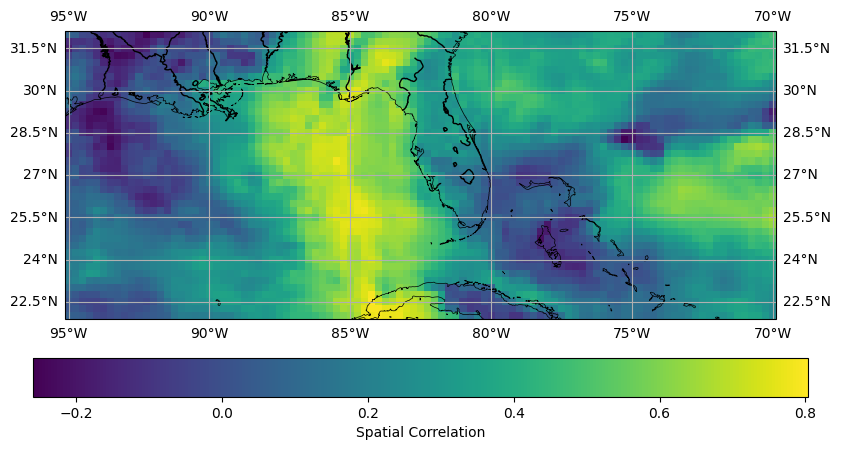

In [55]:
fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('Spatial Correlation')

# Add gridlines
ax.gridlines(draw_labels=True)

# Show the plot
plt.show()

ax.set_title(f'Correlation between ws10 and tp', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);



In [56]:
correlations_filtered = correlations.where(combined_mask)

temp = correlations_filtered.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

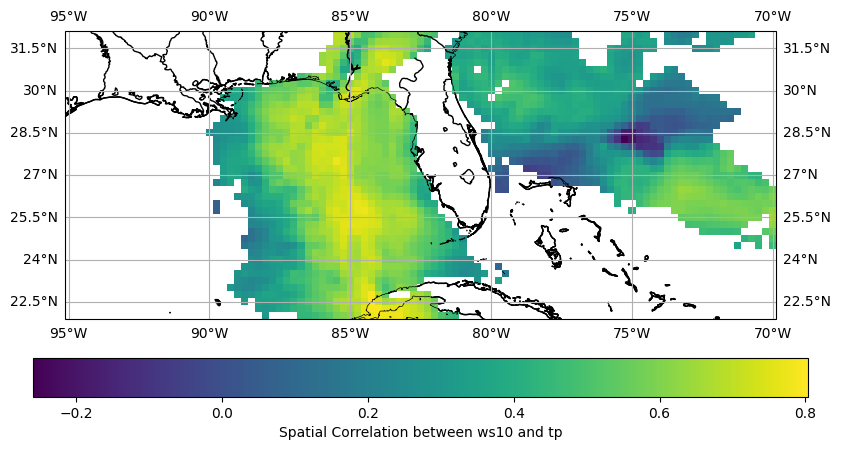

In [57]:
fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('Spatial Correlation between ws10 and tp')

# Add gridlines
ax.gridlines(draw_labels=True)

# Show the plot
plt.show()

ax.set_title(f'Correlation between ws10 and tp', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

In [59]:
df_temp = pd.merge(df_combined, extra.sp, on=['time','latitude','longitude'], how='left')
df_complete = pd.merge(df_temp, extra.sst, on=['time','latitude','longitude'], how='left')

In [60]:
df_complete

ws10        tp          sp  \
time                latitude longitude                                   
2018-10-06 00:00:00 32.0     -95.00     3.369741  0.000000   99845.125   
                             -94.75     2.703256  0.000000   99841.125   
                             -94.50     1.997314  0.000000  100076.125   
                             -94.25     1.765947  0.000000  100296.125   
                             -94.00     1.706438  0.000000  100436.125   
...                                          ...       ...         ...   
2018-10-15 23:00:00 22.0     -71.00     8.791275  0.000017  101665.000   
                             -70.75     8.858593  0.000024  101677.000   
                             -70.50     8.850461  0.000047  101658.000   
                             -70.25     8.766910  0.000051  101649.000   
                             -70.00     8.626667  0.000080  101670.000   

                                               sst  
time                latitude longitude              
2018-10-06 00:00:00 32.0     -95.00            NaN  
                             -94.75            NaN  
                             -94.50            NaN  
                             -94.25            NaN  
                             -94.00            NaN  
...                                            ...  
2018-10-15 23:00:00 22.0     -71.00     301.933594  
                             -70.75     301.979492  
                             -70.50     302.021484  
                             -70.25     301.994141  
                             -70.00     301.985352  

[993840 rows x 4 columns]

In [61]:
def corr_plot(data):

    data_filtered = data.where(combined_mask)

    temp = data_filtered.unstack()
    lat = temp.index.values
    lon = temp.columns.values
    data_grid = temp.values

    fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

    #ax.set_extent([-70, -95, 32, 22])

    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
    ax.add_feature(cfeature.RIVERS, edgecolor='black')

    heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

    # Add a colorbar
    cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
    cbar.set_label('Spatial Correlation')

    # Add gridlines
    ax.gridlines(draw_labels=True)

    # Show the plot
    plt.show()

    ax.set_title(f'Correlation between ws10 and tp', fontsize=16)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12);

In [62]:
ws10_sp_corr = df_complete.groupby(["latitude","longitude"]).apply(lambda x: x['ws10'].corr(x['sp']))
ws10_sst_corr = df_complete.groupby(["latitude","longitude"]).apply(lambda x: x['ws10'].corr(x['sst']))
tp_sp_corr = df_complete.groupby(["latitude","longitude"]).apply(lambda x: x['sp'].corr(x['tp']))
tp_sst_corr = df_complete.groupby(["latitude","longitude"]).apply(lambda x: x['sst'].corr(x['tp']))

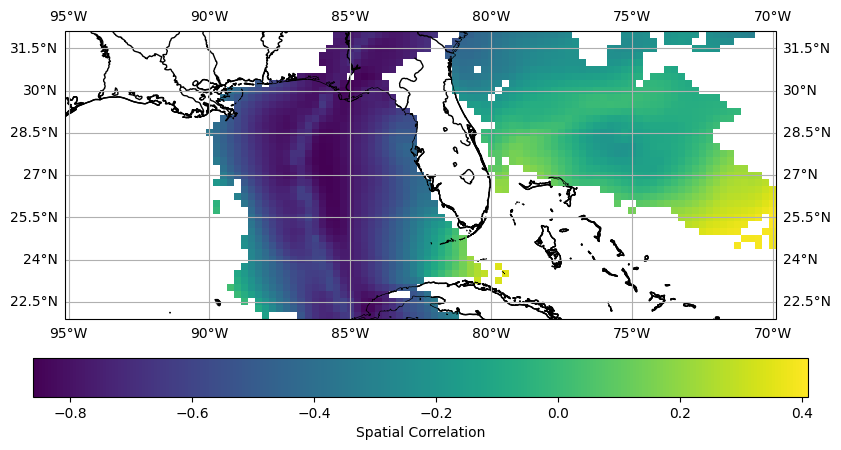

In [63]:
corr_plot(ws10_sp_corr)

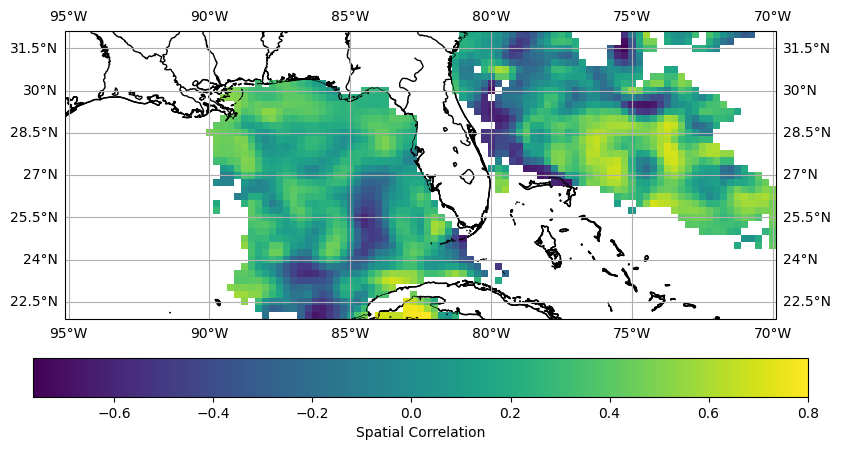

In [64]:
corr_plot(ws10_sst_corr)

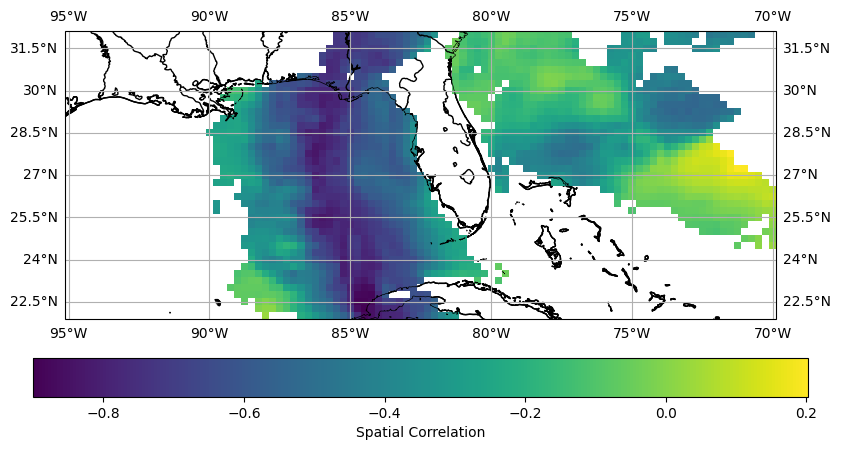

In [65]:
corr_plot(tp_sp_corr)

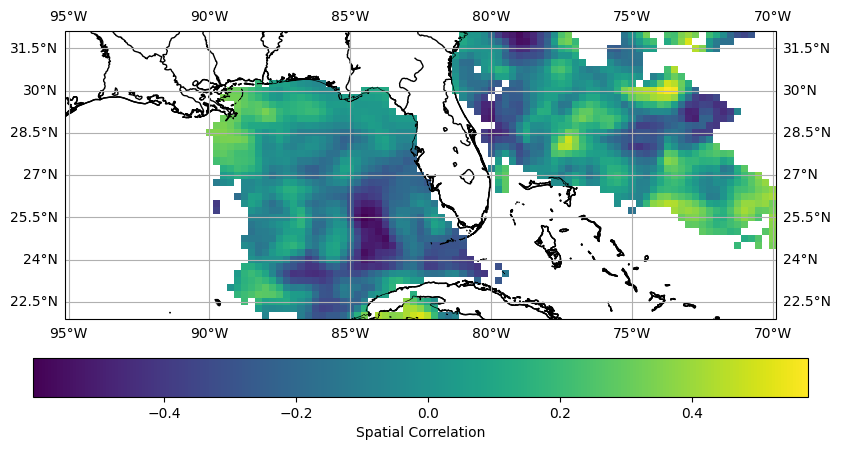

In [66]:
corr_plot(tp_sst_corr)

Temporal Filtering

In [67]:
specific_point= df_complete.loc[:,30.0,-77.0]

In [68]:
specific_point

,ws10,tp,sp,sst
time,,,,
2018-10-06 00:00:00,3.271053,0.000000e+00,101824.1250,301.556885
2018-10-06 01:00:00,3.177055,0.000000e+00,101846.9375,301.556885
2018-10-06 02:00:00,3.297256,0.000000e+00,101872.5000,301.556885
2018-10-06 03:00:00,3.283275,0.000000e+00,101912.4375,301.556885
2018-10-06 04:00:00,2.854419,0.000000e+00,101870.4375,301.556885
...,...,...,...,...
2018-10-15 19:00:00,6.789339,3.814697e-06,101975.3750,301.396484
2018-10-15 20:00:00,6.540404,9.536743e-07,101943.3750,301.396484
2018-10-15 21:00:00,6.148213,2.384186e-06,101977.8125,301.396484


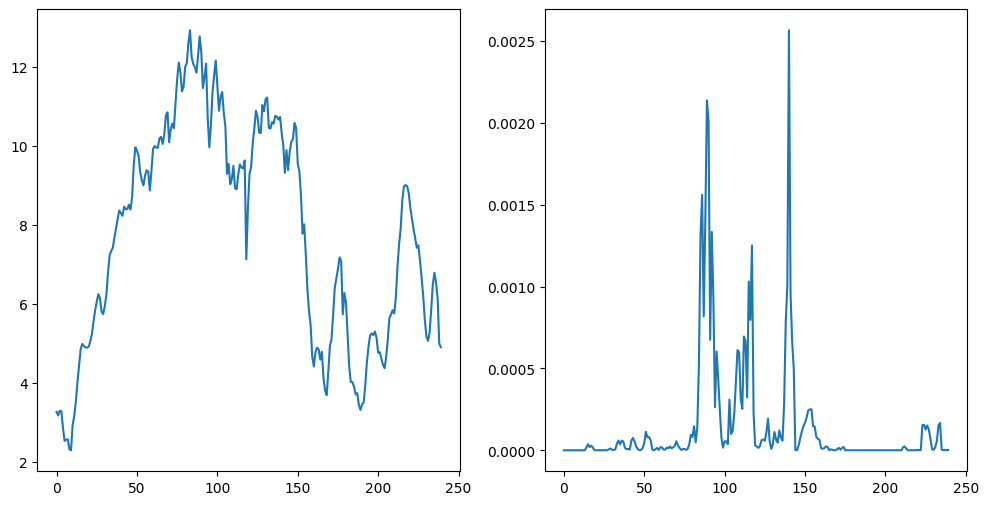

In [71]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(specific_point.ws10.values)

plt.subplot(122)
plt.plot(specific_point.tp.values);